# Zadanie

Wykorzystując zbiór danych oraz model bazowy stworzony podczas pierwszego laboratorium,
przeprowadź proces optymalizacji klasyfikacji. Skoncentruj się na doborze najlepszego modelu,
dostrojeniu jego hiperparametrów, ocenie jakości oraz analizie wyników.

1. W pierwszym kroku przeprowadź testowanie różnych modeli klasyfikacyjnych na przygotowanym
zbiorze danych, porównując ich skuteczność. 

2. Oceń skuteczność modeli na podstawie metryk. Po
wyborze najlepszego modelu przeprowadź dostrajanie jego hiperparametrów.

3. Po optymalizacji przeprowadź szczegółową analizę jakości modelu. 

4. Na zakończenie wykonaj
analizę istotności cech w modelu, jeśli to możliwe.

5. Sporządź wnioski i obserwacje na temat działania modelu

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignoruj ostrzeżenia, aby output był czystszy
warnings.filterwarnings('ignore')


In [2]:
# Dane

try:
    df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv')
except Exception as e:
    print(f"Nie udało się pobrać pliku z URL, spróbuj pobrać ręcznie diabetes.csv i umieścić w katalogu. Błąd: {e}")
    # Przykładowe stworzenie DataFrame w przypadku braku dostępu (identyczne jak w poprzednim pliku)
    data = {
        'Pregnancies': [6, 1, 8, 1, 0, 5, 3, 10, 2, 8],
        'Glucose': [148, 85, 183, 89, 137, 116, 78, 115, 197, 125],
        'BloodPressure': [72, 66, 64, 66, 40, 74, 50, 0, 70, 96],
        'SkinThickness': [35, 29, 0, 23, 35, 0, 88, 0, 45, 0],
        'Insulin': [0, 0, 0, 94, 168, 0, 32, 0, 543, 0], # Zmieniona kolejność danych, aby pasowały do SkinThickness w poprzednim notebooku
        'BMI': [33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31.0, 35.3, 30.5, 0],
        'DiabetesPedigreeFunction': [0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.248, 0.134, 0.158, 0.232],
        'Age': [50, 31, 32, 21, 33, 30, 26, 29, 53, 54],
        'Outcome': [1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
    }
    df = pd.DataFrame(data)


In [3]:
# Cleanup

# Usunięcie duplikatów
df.drop_duplicates(inplace=True)

# Obsługa braków danych (0 jako NaN, potem uzupełnienie medianą)
cols_with_zeros_as_nan = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros_as_nan:
    df[col] = df[col].replace(0, np.nan)
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# Podział na cechy (X) i zmienną docelową (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Balansowanie zbioru danych za pomocą SMOTE (tylko jeśli jest duża dysproporcja)
if y.value_counts()[0] / y.value_counts()[1] > 2 or y.value_counts()[1] / y.value_counts()[0] > 2:
    print("Zbiór jest niezbalansowany, stosuję SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X = X_resampled
    y = y_resampled
else:
    print("Zbiór jest wystarczająco zbalansowany, pomijam SMOTE.")

Zbiór jest wystarczająco zbalansowany, pomijam SMOTE.


In [4]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Skalowanie zmiennych numerycznych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Przygotowanie danych zakończone.\n")

Przygotowanie danych zakończone.



In [5]:
# Testowanie modeli klasyfikacyjnych

models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True), # probability=True potrzebne dla ROC AUC
    'K-Nearest Neighbors': KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    print(f"\nTrenowanie modelu: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else [0]*len(y_test) # Obsługa SVC bez predict_proba domyślnie

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if hasattr(model, 'predict_proba') else np.nan

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

# Wyświetlanie wyników w formie tabeli
results_df = pd.DataFrame(results).T
print("\n--- Porównanie wyników bazowych modeli ---")
print(results_df.sort_values(by='F1-Score', ascending=False))


Trenowanie modelu: Logistic Regression
  Accuracy: 0.7292
  Precision: 0.6364
  Recall: 0.5224
  F1-Score: 0.5738
  ROC AUC: 0.8239

Trenowanie modelu: Decision Tree
  Accuracy: 0.6875
  Precision: 0.5686
  Recall: 0.4328
  F1-Score: 0.4915
  ROC AUC: 0.6284

Trenowanie modelu: Random Forest
  Accuracy: 0.7448
  Precision: 0.6552
  Recall: 0.5672
  F1-Score: 0.6080
  ROC AUC: 0.8030

Trenowanie modelu: Gradient Boosting
  Accuracy: 0.7448
  Precision: 0.6607
  Recall: 0.5522
  F1-Score: 0.6016
  ROC AUC: 0.8187

Trenowanie modelu: Support Vector Machine
  Accuracy: 0.7396
  Precision: 0.6545
  Recall: 0.5373
  F1-Score: 0.5902
  ROC AUC: 0.7943

Trenowanie modelu: K-Nearest Neighbors
  Accuracy: 0.7344
  Precision: 0.6379
  Recall: 0.5522
  F1-Score: 0.5920
  ROC AUC: 0.7751

--- Porównanie wyników bazowych modeli ---
                        Accuracy  Precision    Recall  F1-Score   ROC AUC
Random Forest           0.744792   0.655172  0.567164  0.608000  0.802985
Gradient Boosting    

In [6]:
# Auto-wybór modelu

best_model_name = results_df['F1-Score'].idxmax()
print(f"Model wybrany do optymalizacji: {best_model_name}")

Model wybrany do optymalizacji: Random Forest


In [8]:
if best_model_name == 'Random Forest':
    model_to_optimize = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Logistic Regression':
    model_to_optimize = LogisticRegression(random_state=42, solver='liblinear')
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }
elif best_model_name == 'Gradient Boosting':
    model_to_optimize = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'Support Vector Machine':
    model_to_optimize = SVC(random_state=42, probability=True)
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
elif best_model_name == 'K-Nearest Neighbors':
    model_to_optimize = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
elif best_model_name == 'Decision Tree':
    model_to_optimize = DecisionTreeClassifier(random_state=42)
    param_grid = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
else:
    print("Nie zdefiniowano parametrów dla wybranego modelu. Używam domyślnego GridSearchCV z pustym słownikiem.")
    param_grid = {} # Pusty słownik, jeśli nie ma zdefiniowanych parametrów
    
# Użycie GridSearchCV do wyszukania najlepszych hiperparametrów
print(f"Rozpoczynam wyszukiwanie najlepszych hiperparametrów dla {best_model_name}...")
grid_search = GridSearchCV(model_to_optimize, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"\nNajlepsze hiperparametry dla {best_model_name}: {grid_search.best_params_}")
print(f"Najlepszy wynik F1-Score w walidacji krzyżowej: {grid_search.best_score_:.4f}")

# Ocena zoptymalizowanego modelu na zbiorze testowym
y_pred_optimized = best_model.predict(X_test_scaled)
y_pred_proba_optimized = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else [0]*len(y_test)

print("\n--- Ocena zoptymalizowanego modelu na zbiorze testowym ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimized):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

Rozpoczynam wyszukiwanie najlepszych hiperparametrów dla Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Najlepsze hiperparametry dla Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Najlepszy wynik F1-Score w walidacji krzyżowej: 0.6421

--- Ocena zoptymalizowanego modelu na zbiorze testowym ---
Accuracy: 0.7448
Precision: 0.6552
Recall: 0.5672
F1-Score: 0.6080
ROC AUC Score: 0.8087



Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       125
           1       0.66      0.57      0.61        67

    accuracy                           0.74       192
   macro avg       0.72      0.70      0.71       192
weighted avg       0.74      0.74      0.74       192


Macierz konfuzji dla zoptymalizowanego modelu:
[[105  20]
 [ 29  38]]


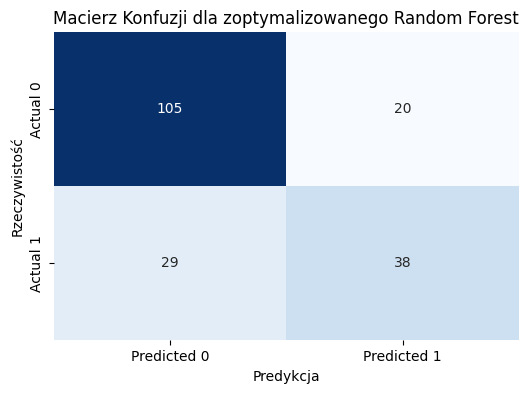

<Figure size 800x600 with 0 Axes>

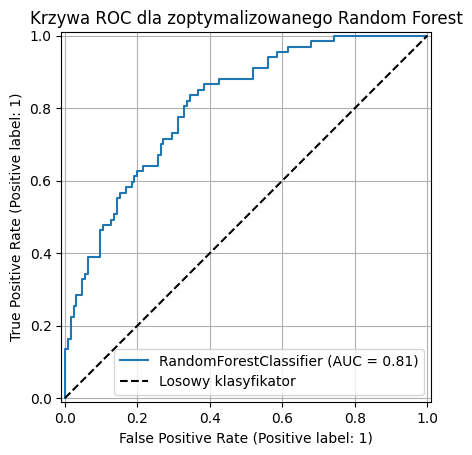

<Figure size 800x600 with 0 Axes>

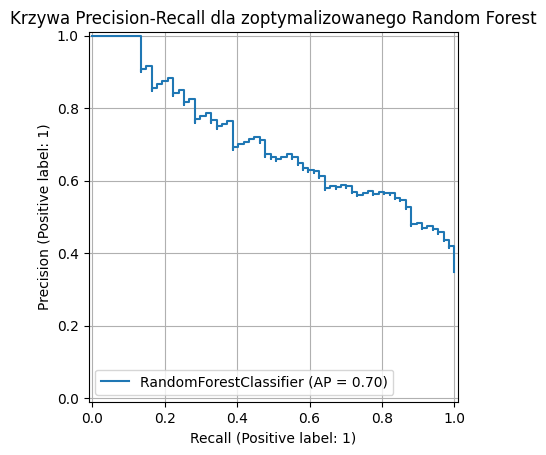

In [9]:
# Analiza pooptymalizacyjna

print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred_optimized))

print("\nMacierz konfuzji dla zoptymalizowanego modelu:")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print(cm_optimized)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Macierz Konfuzji dla zoptymalizowanego {best_model_name}')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywistość')
plt.show()

# Krzywa ROC
if hasattr(best_model, 'predict_proba'):
    plt.figure(figsize=(8, 6))
    RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)
    plt.title(f'Krzywa ROC dla zoptymalizowanego {best_model_name}')
    plt.plot([0, 1], [0, 1], 'k--', label='Losowy klasyfikator')
    plt.legend()
    plt.grid(True)
    plt.show()

# Krzywa Precision-Recall
if hasattr(best_model, 'predict_proba'):
    plt.figure(figsize=(8, 6))
    PrecisionRecallDisplay.from_estimator(best_model, X_test_scaled, y_test)
    plt.title(f'Krzywa Precision-Recall dla zoptymalizowanego {best_model_name}')
    plt.grid(True)
    plt.show()


--- Analiza istotności cech ---

Istotność cech w zoptymalizowanym modelu:
                    Feature  Importance
1                   Glucose    0.312221
5                       BMI    0.161967
7                       Age    0.120863
6  DiabetesPedigreeFunction    0.107691
4                   Insulin    0.093076
0               Pregnancies    0.079109
2             BloodPressure    0.064714
3             SkinThickness    0.060359


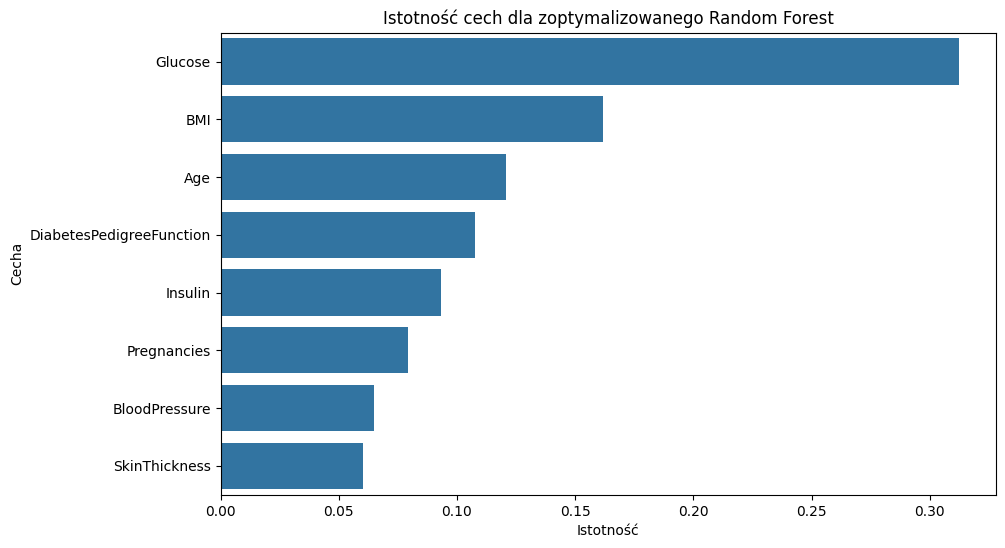

In [10]:
# Analiza istotności cech

print("\n--- Analiza istotności cech ---")

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nIstotność cech w zoptymalizowanym modelu:")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Istotność cech dla zoptymalizowanego {best_model_name}')
    plt.xlabel('Istotność')
    plt.ylabel('Cecha')
    plt.show()
elif hasattr(best_model, 'coef_'):
    print("\nWspółczynniki modelu (dla Regresji Logistycznej):")
    coefs = best_model.coef_[0]
    features = X.columns
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefs, 'Abs_Coefficient': np.abs(coefs)})
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
    print(coef_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=coef_df)
    plt.title(f'Współczynniki (bezwzględne) dla zoptymalizowanej Regresji Logistycznej')
    plt.xlabel('Bezwzględna wartość współczynnika')
    plt.ylabel('Cecha')
    plt.show()

else:
    print("Wybrany model nie posiada atrybutu 'feature_importances_' ani 'coef_' do analizy istotności cech.")

In [13]:
# Wnioski i obserwacje 

print(f"Po przeprowadzeniu analizy, zoptymalizowany model **{best_model_name}** wykazuje następującą skuteczność na danych testowych:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"- Precision: {precision_score(y_test, y_pred_optimized):.4f}")
print(f"- Recall: {recall_score(y_test, y_pred_optimized):.4f}")
print(f"- F1-Score: {f1_score(y_test, y_pred_optimized):.4f}")
print(f"- ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

Po przeprowadzeniu analizy, zoptymalizowany model **Random Forest** wykazuje następującą skuteczność na danych testowych:
- Accuracy: 0.7448
- Precision: 0.6552
- Recall: 0.5672
- F1-Score: 0.6080
- ROC AUC Score: 0.8087
